# GOSTrocks Primer

GOSTrocks is an internal sandbox repository that contains commonly used geospatial functions and operations. This notebooks demonstrates the usage of selected functions.

The repository also contains customized code to process specific datasets (GHSL, OpenStreetMap, Nighttime Lights, Fathom). This code is in constant development as project requirements evolve over time.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](
  https://colab.research.google.com/github/worldbank/GOSTrocks/blob/glevin_review/docs/examples/GOSTrocks_Usage.ipynb
)

## Installation

### From PyPI

```
pip install GOSTrocks
```

### From Source

```
git clone https://github.com/worldbank/GOSTrocks.git
cd GOSTrocks
pip install .
```

## Import Functions

GOSTrocks is broken down into modules of functions that share common elements.

In [2]:
import GOSTrocks.dataMisc as dMisc  # search and download specific datasets
import GOSTrocks.rasterMisc as rMisc  # Raster tools!

## Raster Example

One of the most recurring workflows is to clip and combine raster data from different sources.

Here, we work with population data from WorldPop, and a friction surface from the Malaria Atlas Project, using Ghana as our area of interest.

They are both global datasets with ~1km resolution, so they both need to be clipped and standardized for analysis.

We will use administrative boundaries from the GeoBoundaries API. 

In [3]:
import os
from os.path import join, exists
import urllib.request

import rasterio as rio
from rasterio.plot import show

import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [4]:
country = "Ghana"
iso = "GHA"

### Get Boundaries

In [5]:
dMisc.get_geoboundaries?

Signature:
dMisc.get_geoboundaries(
    iso3,
    level,
    geo_api='https://www.geoboundaries.org/api/current/gbOpen/{iso3}/{adm}/',
)
Docstring:
Download boundaries dataset from geobounadries

Parameters
----------
iso3 : bool
    ISO3 code of country to download
level : str
    Admin code to download in format of "ADM1" or "ADM2"
geo_api : str, optional
    by default "https://www.geoboundaries.org/api/current/gbOpen/{iso3}/{adm}/"

Returns
-------
gpd.GeoDataFrame
    spatial data representing the administrative boundaries
File:      ~/Documents/WorldBank/GOSTrocks/src/GOSTrocks/dataMisc.py
Type:      function

<Axes: >

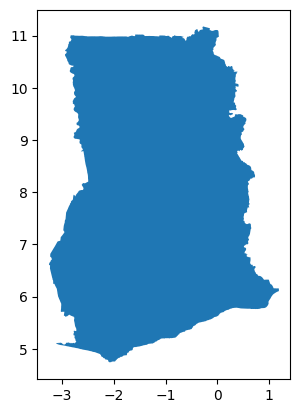

In [6]:
gdf = dMisc.get_geoboundaries(iso, level="ADM0")
gdf.plot()

### Download Population Data

In [7]:
wp_url = f"https://data.worldpop.org/GIS/Population/Global_2000_2020_1km/2020/{iso.upper()}/{iso.lower()}_ppp_2020_1km_Aggregated.tif"
wp_url

'https://data.worldpop.org/GIS/Population/Global_2000_2020_1km/2020/GHA/gha_ppp_2020_1km_Aggregated.tif'

In [8]:
wp_path = join(
    "..", "data", f"{iso}_ppp_2020_1km_Aggregated_UNadj.tif"
)  # Download from link above
if not exists(wp_path):
    urllib.request.urlretrieve(wp_url, wp_path)

In [9]:
src_pop = rio.open(wp_path)

(np.float64(-3.251249987361092),
 np.float64(1.190416661538908),
 np.float64(4.732916852582885),
 np.float64(11.174583493482885))

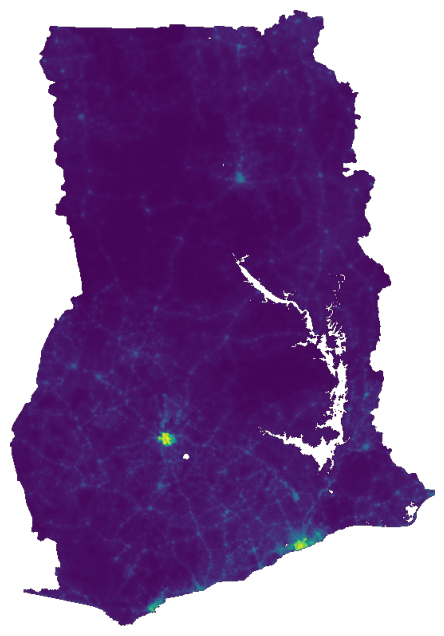

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
show(src_pop, norm=colors.PowerNorm(gamma=0.5), cmap="viridis", ax=ax)
plt.axis("off")

### Clip Global Friction Surface

In [11]:
gfs_path = "/Users/glevin/Documents/WorldBank/GOSTrocks/2020_motorized_friction_surface.geotiff"
src_travel = rio.open(gfs_path)

KeyboardInterrupt: 

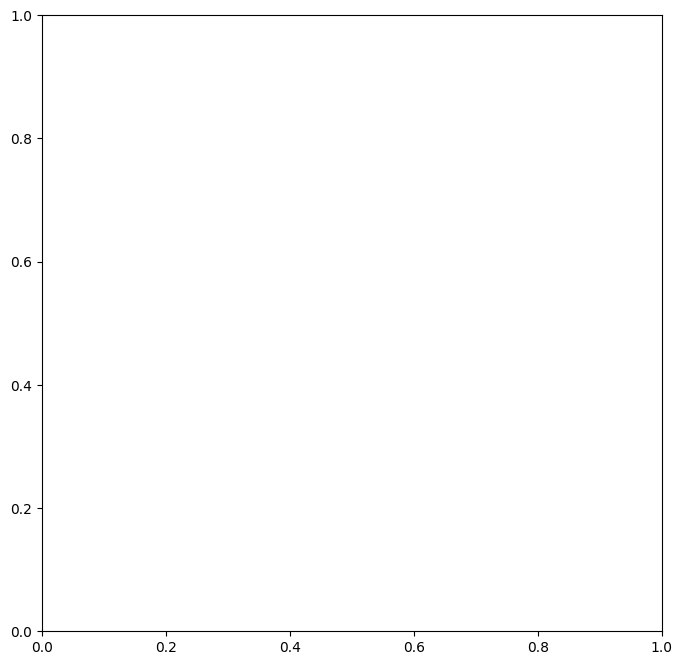

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# show(src_travel, norm=colors.PowerNorm(gamma=0.2), cmap="magma", ax=ax)
# plt.axis("off")

In [13]:
rMisc.clipRaster?

Signature: rMisc.clipRaster(inR, inD, outFile=None, crop=True)
Docstring:
Clip input raster to provided geodataframe

Parameters
----------
inR : rasterio.DatasetReader
    Input raster to clip
inD : geopandas.GeoDataFrame
    GeoDataFrame containing the clipping geometry
outFile : str, optional
    File to write the clipped raster to, by default None
crop : bool, optional
    Whether to crop the raster to the unary_union of the GeoDataFrame (True) or to the bounding box (False), by default True

Returns
-------
tuple
    A tuple containing the clipped raster and its metadata.
File:      ~/Documents/WorldBank/GOSTrocks/src/GOSTrocks/rasterMisc.py
Type:      function

In [14]:
out_travel = join("..", "data", f"{iso.upper()}_2020_motorized_friction_surface.tif")
surface, surface_meta = rMisc.clipRaster(
    src_travel, gdf, outFile=out_travel, crop=False
)

(np.float64(-0.5), np.float64(534.5), np.float64(772.5), np.float64(-0.5))

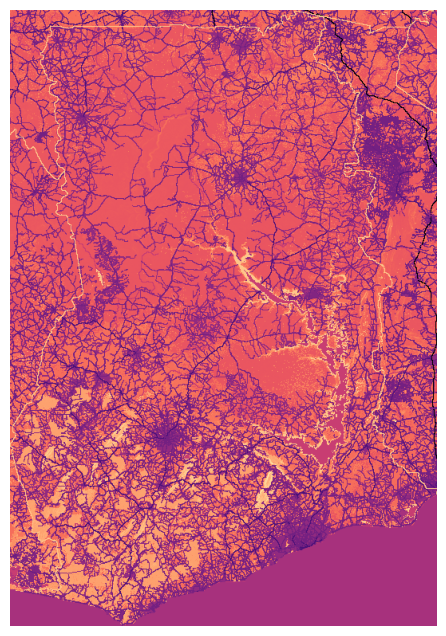

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
show(surface, norm=colors.PowerNorm(gamma=0.2), cmap="magma", ax=ax)
plt.axis("off")

### Standardize Rasters

Align the population raster to the friction surface, ensuring that they have the same extent and resolution.

In [17]:
rMisc.standardizeInputRasters?

Signature:
rMisc.standardizeInputRasters(
    inR1,
    inR2,
    inR1_outFile='',
    resampling_type='nearest',
)
Docstring:
Standardize inR1 to inR2: changes crs, extent, and resolution.

:param inR1: rasterio object for raster to be modified
:type inR1: rasterio.DatasetReader
:param inR2: rasterio object to be standardized to
:type inR12 rasterio.DatasetReader
:param inR1_outfile: path to create output raster file of standardized inR1, default is '', which means nothing is written
:type inR1: string
:param resampling_type: how to perform spatial resampling; options are nearest (default), cubic, or sum
:type resampling_type: string
:return: array of numpy array, and rasterio metadata
:rtype: array
File:      ~/Documents/WorldBank/GOSTrocks/src/GOSTrocks/rasterMisc.py
Type:      function

In [18]:
src_travel_clipped = rio.open(out_travel)

In [19]:
pop_std, pop_meta = rMisc.standardizeInputRasters(
    src_pop, src_travel_clipped, resampling_type="nearest"
)

Original population raster metadata:

In [20]:
src_pop.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -99999.0,
 'width': 533,
 'height': 773,
 'count': 1,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 'transform': Affine(0.0083333333, 0.0, -3.251249987361092,
        0.0, -0.0083333333, 11.174583493482885)}

New population metadata aligned with travel surface:

In [21]:
pop_meta, surface_meta

({'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': -99999.0,
  'width': 535,
  'height': 773,
  'count': 1,
  'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
  'transform': Affine(0.008333333333333333, 0.0, -3.2583333333333258,
         0.0, -0.008333333333333333, 11.174999999999997)},
 {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': -9999.0,
  'width': 535,
  'height': 773,
  'count': 1,
  'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4

In [22]:
src_pop.close()
src_travel.close()
src_travel_clipped.close()

In [23]:
os.remove(out_travel)
os.remove(wp_path)